In [1]:
from __future__ import print_function, division

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from pathlib import Path
import copy
import torchsummary
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm
from barbar import Bar
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import cohen_kappa_score
cudnn.benchmark = True
plt.ion()   # interactive mode

selected_gpu = 1 # here you select the GPU used (0, 1 or 2)
device = torch.device("cuda:" + str(selected_gpu) if
torch.cuda.is_available() else "cpu")
print(f'the device is {device}')


the device is cuda:1


In [2]:
#if running locally
notebook_path = Path().cwd()
#if running in colab
# from google.colab import drive
# drive._mount('/content/drive')
#notebook_path = Path('/content/drive/MyDrive/MAIA/3rd_semester/CAD/Projecte/Deep_Learning/notebooks')

project_path = notebook_path.parent
repo_path = project_path.parent
os.chdir(notebook_path)
print(f'The current directory is {Path().cwd()}')

The current directory is /home/user7/skin_lesion_classification/Deep_Learning/notebooks


# MAIN

## Hyperparameters
- For both preprocessing and training

In [3]:
#@markdown ## Hyperparameters
batch_size =  16 #@param
learning_rate =  1e-5 #@param
num_workers =  2 #@param
num_epochs =  50 #@param

#early stopping
patience = 12 #@param
scheduler_patience = 4 #@param

#challenge type (binary or 3-classes)
num_classes = 3 #@param

#image size 
height = 450
width = 600

#cropping
center_crop = 448

## Datatransforms
- Define the preprocessing steps and the data augmentation approaches

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((height, width)),
        transforms.CenterCrop(center_crop), #because the information of the image is centered all the time
        transforms.RandomAffine(90,shear=20,scale=(0.8,1.2)), #random affine homographies
        transforms.RandomHorizontalFlip(), #flips
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=(0.7,1.3), contrast=(0.7,1.3), saturation=(0.7,1.3)), #changing color brightness, contrast and saturation
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #Imagenet mean and std
    ]),
    'val': transforms.Compose([ #for validation we only resize and crop
        transforms.Resize((height, width)),
        #transforms.CenterCrop(center_crop),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([ #for test we only resize and crop
        transforms.Resize((height, width)),
        #transforms.CenterCrop(center_crop),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## Dataloading

In [5]:
#directory of the data
data_dir = repo_path /'Machine_Learning'/'images' / '3_classes'
folders_list = ['train', 'val', 'test']

#get the data info
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in folders_list}
#get dataloader
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=num_workers)
              for x in folders_list}
#size of datasets
dataset_sizes = {x: len(image_datasets[x]) for x in folders_list}
#get classes names
class_names = image_datasets['train'].classes
#print info
for key in dataset_sizes.keys():
    print(f'Number of {key} images: {dataset_sizes[key]}')


Number of train images: 5082
Number of val images: 1270
Number of test images: 2121


## Get class weights
- To balance the classes, we use the class weights from scikit-learn using the training set

In [6]:
#using scikit-learn, we compute the weights of each class
class_weights = compute_class_weight(class_weight= 'balanced', classes= np.unique(image_datasets['train'].targets), y= image_datasets['train'].targets)
print(f'Class weights: {class_weights}, in the order: {class_names}')
class_weights = torch.FloatTensor(class_weights).to(device)

Class weights: [0.84997491 0.62440103 4.50531915], in the order: ['bcc', 'mel', 'scc']


## Visualizing some images

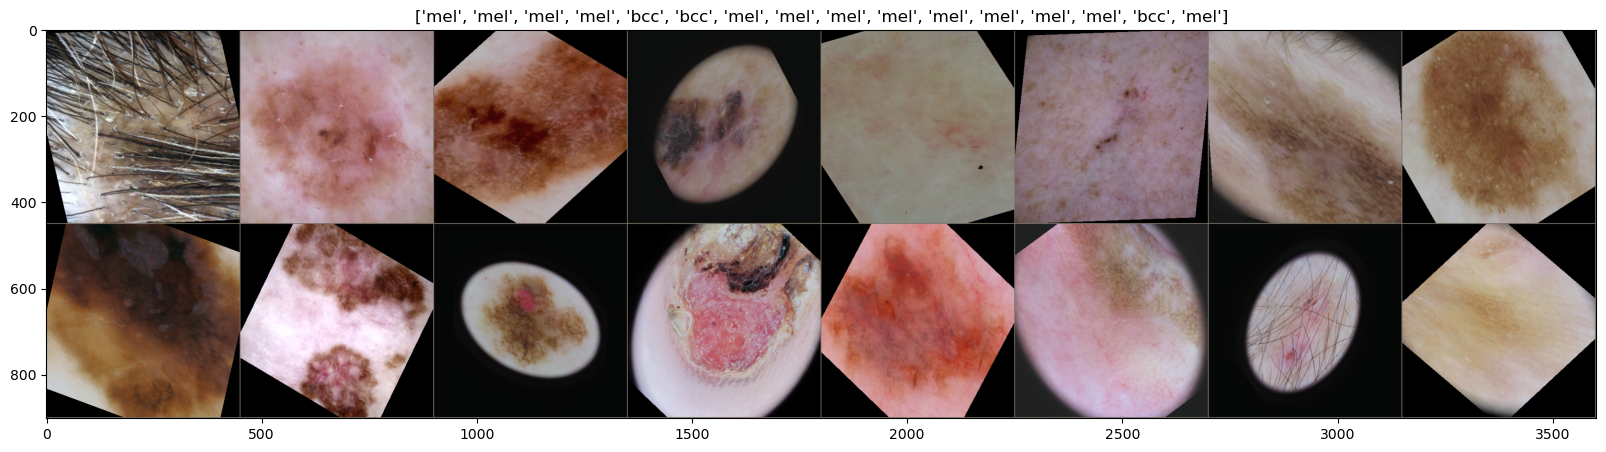

In [7]:
def imshow(input:torch.Tensor, title=None):
    """shows a preprocessed tensor in its original form

    Args:
        input (torch.Tensor): input tensor
        title (_type_, optional): _description_. Defaults to None.
    """
    #get numpy, and put color at the end
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    #scale back
    input = std * input + mean
    input = np.clip(input, 0, 1)
    #plot
    plt.figure(figsize=(20,10))
    plt.imshow(input)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid (fused_image) from batch
out = torchvision.utils.make_grid(inputs)
#show the fused_image
imshow(out, title=[class_names[x] for x in classes])

## Analysing the architecture of the network

In [8]:
# # Viewing the Architecture and Finding the Cross-Section of Transfer Learning
# sample_net = torchvision.models.googlenet(weights='DEFAULT') 
# torchsummary.summary(sample_net, (3, 448, 448))

## Model setting

In [10]:
model_name = 'resnet34'
#get the model
model = getattr(torchvision.models, model_name)(weights='DEFAULT')

#change last layer to have two outputs
in_fts_fc = model.fc.in_features
model.fc = nn.Linear(in_fts_fc, num_classes)

#################################3
continue_training = False #@param
continue_from_epoch =  9 #@param #if continue_training is True, this is the last epoch that was trained (you will continue with the next one)
pretrained_model_save_path = project_path / 'data'/'models'/'3_classes' / f'{model_name}_epoch{continue_from_epoch}.pt' #@param
#continue training
if continue_training:
    model.load_state_dict(torch.load(pretrained_model_save_path))
    print(f'model loaded: {pretrained_model_save_path}')
else:
    continue_from_epoch = 0
    print(f'training from scratch\nStarting from epoch {continue_from_epoch}')
#################################3

#send model to device
model = model.to(device)
#saving path
model_save_path = project_path / 'data'/'models'/'3_classes' / f'{model_name}.pt'

training from scratch
Starting from epoch 0


## Useful functions

In [11]:
def get_accuracy(predicted, labels):
    """gets the accuracy of a batch

    Args:
        predicted (_type_): predicted labels
        labels (_type_): true labels

    Returns:
        int, int: batch length, correct predictions
    """
    batch_len, correct= 0, 0
    batch_len = labels.size(0)
    correct = (predicted == labels).sum().item()
    return batch_len, correct

def evaluate(model, val_dataloader, criterion):
    """gets validation losses and accuracy

    Args:
        model (_type_): model trained
        val_dataloader (_type_): data loader for validation
        criterion (_type_): loss function

    Returns:
        float, float: losses and accuracy of validation set
    """
    losses= 0
    num_samples_total=0
    correct_total=0
    model.eval()
    for inputs, labels in Bar(val_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            out = model(inputs)
            _, predicted = torch.max(out, 1)
            loss = criterion(out, labels)
        losses += loss.item() 
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
    accuracy = correct_total/num_samples_total
    losses = losses/len(val_dataloader)
    return losses, accuracy

def evaluate_kappa(model, val_dataloader, criterion):
    """gets validation losses and accuracy

    Args:
        model (_type_): model trained
        val_dataloader (_type_): data loader for validation
        criterion (_type_): loss function

    Returns:
        float, float: losses and accuracy of validation set
    """
    losses= 0
    num_samples_total=0
    correct_total=0
    model.eval()
    #concatenate predictions
    preds = torch.tensor([], dtype=torch.long).to(device)
    labels_all = torch.tensor([], dtype=torch.long).to(device)
    for inputs, labels in Bar(val_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            out = model(inputs)
            _, predicted = torch.max(out, 1)
            loss = criterion(out, labels)
        losses += loss.item() 
        b_len, corr = get_accuracy(predicted, labels)
        #concatenate predictions
        preds = torch.cat((preds, predicted), 0)
        labels_all = torch.cat((labels_all, labels), 0)
        num_samples_total +=b_len
        correct_total +=corr
    #get kappa
    kappa = cohen_kappa_score(preds.cpu().numpy(), labels_all.cpu().numpy())
    accuracy = correct_total/num_samples_total
    losses = losses/len(val_dataloader)
    return losses, accuracy, kappa

class EarlyStopping:
    """Early Stops the Training if the Validation Loss doesn't improve after a predefined Patience."""
    def __init__(self, patience=7, verbose=False, delta=0):

        self.patience     = patience
        self.verbose      = verbose
        self.counter      = 0
        self.best_score   = None
        self.early_stop   = False
        self.val_loss_min = np.Inf
        self.delta        = delta

    def __call__(self, val_loss, model, model_save_path):
        """what to do when calling the class

        Args:
            val_loss (_type_): validation loss
            model (_type_): trained model
            model_save_path (Path): path to save the model state dict
        """

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, model_save_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping Counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, model_save_path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, model_save_path):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation Loss Decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), model_save_path)
        self.val_loss_min = val_loss

## Training

Start by defining:
- Checkpoint model
- loss function
- optimizer
- scheduler

In [12]:
# Clearing the GPU Cache
torch.cuda.empty_cache()
     
print("Training with: " + model_name)

#loss function and optimizer, with scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min', patience=3, verbose=True)

Training with: resnet34


In [13]:
# Initializing the early_stopping
early_stopping = EarlyStopping(patience=patience, verbose=True)

#list to store statistics
accuracy      = []
val_accuracy  = []
losses        = []
val_losses    = []
kappa        = []
val_kappas    = []
best_accuracy = 0
best_kappa    = 0

for epoch in range(continue_from_epoch, num_epochs): #going through the dataset multiple times
    training_loss      = 0.0
    correct_total     = 0.0
    num_samples_total = 0.0
    for i, data in enumerate(tqdm(dataloaders['train'])):
        # Getting the Inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Setting the Parameter Gradients to Zero
        optimizer.zero_grad()

        # Forward Pass + Backward Pass + Optimize
        outputs = model(inputs)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Computing Accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        training_loss += loss.item()
    #train statistics
    training_loss /= len(dataloaders['train'])
    train_accuracy = correct_total/num_samples_total
    #validation statistics
    val_loss, val_acc, val_kappa = evaluate_kappa(model, dataloaders['val'], criterion)
    print(val_kappa)
    #update scheduler
    scheduler.step(val_loss)
    
    print(f'Epoch: {epoch+1}')
    print('Training Loss: %.3f , Training Accuracy:%.3f => Validation Loss: %.3f, Validation Accuracy: %.3f ' %(training_loss, train_accuracy,val_loss, val_acc))

    losses.append(training_loss)     # List Containing the Training Losses
    val_losses.append(val_loss)     # List Containing the Validation Losses
    accuracy.append(train_accuracy) # List Containing the Training Accuracy
    val_accuracy.append(val_acc)    # List Containing the Validation Accuracy
    val_kappas.append(val_kappa)    # List Containing the Validation Accuracy

    #save statistics
    
    df = pd.DataFrame({'loss':losses, 'val_loss':val_losses, 'accuracy':accuracy, 'val_accuracy':val_accuracy, 'val_kappa':val_kappas})
    df.to_csv(project_path / 'data'/'results'/ f'{model_name}_stats_multi.csv', index=False)
    
    #if the validation accuracy is better than the best accuracy, save the model
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), project_path / 'data'/'models'/ '3_classes'/f'{model_name}_bestacc.pt')
    #if the validation kappa is better than the best kappa, save the model
    if val_kappa > best_kappa:
        best_kappa = val_kappa
        torch.save(model.state_dict(), project_path / 'data'/'models'/ '3_classes'/f'{model_name}_bestkappa.pt')
    
    # early_stopping needs Validation Loss to check if it decreases and if so, it makes a Checkpoint of the Current Model
    early_stopping(val_loss, model, model_save_path)
    
    if early_stopping.early_stop:
        print("Early Stopping")
        break

print('Finished Training')

100%|██████████| 318/318 [02:10<00:00,  2.44it/s]


1270/1270: [===============================>] - ETA 2.9sss
0.6579846796286938
Epoch: 1
Training Loss: 0.844 , Training Accuracy:0.681 => Validation Loss: 0.679, Validation Accuracy: 0.809 
Validation Loss Decreased (inf --> 0.679440).  Saving model ...


100%|██████████| 318/318 [01:50<00:00,  2.87it/s]


1270/1270: [===============================>] - ETA 0.7ss
0.6951881370518204
Epoch: 2
Training Loss: 0.702 , Training Accuracy:0.746 => Validation Loss: 0.614, Validation Accuracy: 0.825 
Validation Loss Decreased (0.679440 --> 0.613786).  Saving model ...


100%|██████████| 318/318 [01:49<00:00,  2.90it/s]


1270/1270: [===============================>] - ETA 0.7ss
0.581240108034048
Epoch: 3
Training Loss: 0.596 , Training Accuracy:0.790 => Validation Loss: 0.571, Validation Accuracy: 0.736 
Validation Loss Decreased (0.613786 --> 0.571216).  Saving model ...


100%|██████████| 318/318 [01:49<00:00,  2.90it/s]


1270/1270: [===============================>] - ETA 0.7ss
0.6153630153196918
Epoch: 4
Training Loss: 0.548 , Training Accuracy:0.802 => Validation Loss: 0.530, Validation Accuracy: 0.762 
Validation Loss Decreased (0.571216 --> 0.529840).  Saving model ...


100%|██████████| 318/318 [01:37<00:00,  3.27it/s]


1270/1270: [===============================>] - ETA 0.7ss
0.58860660390284
Epoch: 5
Training Loss: 0.516 , Training Accuracy:0.815 => Validation Loss: 0.542, Validation Accuracy: 0.739 
EarlyStopping Counter: 1 out of 12


100%|██████████| 318/318 [01:34<00:00,  3.36it/s]


1270/1270: [===============================>] - ETA 0.8ss
0.7096823354104579
Epoch: 6
Training Loss: 0.492 , Training Accuracy:0.822 => Validation Loss: 0.519, Validation Accuracy: 0.830 
Validation Loss Decreased (0.529840 --> 0.518970).  Saving model ...


100%|██████████| 318/318 [01:30<00:00,  3.50it/s]


1270/1270: [===============================>] - ETA 0.8ss
0.7680149632481624
Epoch: 7
Training Loss: 0.453 , Training Accuracy:0.841 => Validation Loss: 0.458, Validation Accuracy: 0.869 
Validation Loss Decreased (0.518970 --> 0.458394).  Saving model ...


100%|██████████| 318/318 [01:33<00:00,  3.41it/s]


1270/1270: [===============================>] - ETA 0.7ss
0.7674533829662564
Epoch: 8
Training Loss: 0.423 , Training Accuracy:0.851 => Validation Loss: 0.435, Validation Accuracy: 0.866 
Validation Loss Decreased (0.458394 --> 0.435129).  Saving model ...


100%|██████████| 318/318 [01:32<00:00,  3.45it/s]


1270/1270: [===============================>] - ETA 0.7ss
0.7462532125836534
Epoch: 9
Training Loss: 0.409 , Training Accuracy:0.849 => Validation Loss: 0.399, Validation Accuracy: 0.850 
Validation Loss Decreased (0.435129 --> 0.398982).  Saving model ...


100%|██████████| 318/318 [01:37<00:00,  3.27it/s]


1270/1270: [===============================>] - ETA 0.8ss
0.7305294712812836
Epoch: 10
Training Loss: 0.369 , Training Accuracy:0.869 => Validation Loss: 0.417, Validation Accuracy: 0.840 
EarlyStopping Counter: 1 out of 12


100%|██████████| 318/318 [01:33<00:00,  3.39it/s]


1270/1270: [===============================>] - ETA 0.8ss
0.7335280466976362
Epoch: 11
Training Loss: 0.364 , Training Accuracy:0.870 => Validation Loss: 0.397, Validation Accuracy: 0.843 
Validation Loss Decreased (0.398982 --> 0.397065).  Saving model ...


100%|██████████| 318/318 [01:33<00:00,  3.39it/s]


1270/1270: [===============================>] - ETA 0.8ss
0.7460803852470234
Epoch: 12
Training Loss: 0.329 , Training Accuracy:0.873 => Validation Loss: 0.391, Validation Accuracy: 0.853 
Validation Loss Decreased (0.397065 --> 0.390656).  Saving model ...


100%|██████████| 318/318 [01:31<00:00,  3.49it/s]


1270/1270: [===============================>] - ETA 0.9ss
0.7641128946664573
Epoch: 13
Training Loss: 0.312 , Training Accuracy:0.882 => Validation Loss: 0.376, Validation Accuracy: 0.862 
Validation Loss Decreased (0.390656 --> 0.375715).  Saving model ...


100%|██████████| 318/318 [01:27<00:00,  3.63it/s]


1270/1270: [===============================>] - ETA 0.8ss
0.7918230366401808
Epoch: 14
Training Loss: 0.294 , Training Accuracy:0.894 => Validation Loss: 0.357, Validation Accuracy: 0.880 
Validation Loss Decreased (0.375715 --> 0.356820).  Saving model ...


100%|██████████| 318/318 [01:28<00:00,  3.61it/s]


1270/1270: [===============================>] - ETA 0.7ss
0.7966100227672117
Epoch: 15
Training Loss: 0.289 , Training Accuracy:0.895 => Validation Loss: 0.370, Validation Accuracy: 0.883 
EarlyStopping Counter: 1 out of 12


100%|██████████| 318/318 [01:30<00:00,  3.53it/s]


1270/1270: [===============================>] - ETA 0.7ss
0.7997311407060129
Epoch: 16
Training Loss: 0.273 , Training Accuracy:0.902 => Validation Loss: 0.453, Validation Accuracy: 0.889 
EarlyStopping Counter: 2 out of 12


100%|██████████| 318/318 [01:29<00:00,  3.55it/s]


1270/1270: [===============================>] - ETA 0.6ss
0.8374887191713474
Epoch: 17
Training Loss: 0.265 , Training Accuracy:0.902 => Validation Loss: 0.405, Validation Accuracy: 0.910 
EarlyStopping Counter: 3 out of 12


100%|██████████| 318/318 [01:26<00:00,  3.68it/s]


1270/1270: [===============================>] - ETA 0.8ss
0.8053531763660595
Epoch 00018: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 18
Training Loss: 0.247 , Training Accuracy:0.907 => Validation Loss: 0.453, Validation Accuracy: 0.891 
EarlyStopping Counter: 4 out of 12


100%|██████████| 318/318 [01:28<00:00,  3.58it/s]


1270/1270: [===============================>] - ETA 0.9ss
0.843650874632335
Epoch: 19
Training Loss: 0.184 , Training Accuracy:0.936 => Validation Loss: 0.358, Validation Accuracy: 0.913 
EarlyStopping Counter: 5 out of 12


100%|██████████| 318/318 [01:25<00:00,  3.70it/s]


1270/1270: [===============================>] - ETA 0.8ss
0.8499607682293988
Epoch: 20
Training Loss: 0.144 , Training Accuracy:0.951 => Validation Loss: 0.374, Validation Accuracy: 0.917 
EarlyStopping Counter: 6 out of 12


100%|██████████| 318/318 [01:23<00:00,  3.81it/s]


1270/1270: [===============================>] - ETA 0.8ss
0.8474352300484523
Epoch: 21
Training Loss: 0.138 , Training Accuracy:0.951 => Validation Loss: 0.374, Validation Accuracy: 0.915 
EarlyStopping Counter: 7 out of 12


100%|██████████| 318/318 [01:25<00:00,  3.73it/s]


1270/1270: [===============================>] - ETA 0.8ss
0.8477089726906525
Epoch 00022: reducing learning rate of group 0 to 1.0000e-07.
Epoch: 22
Training Loss: 0.127 , Training Accuracy:0.957 => Validation Loss: 0.357, Validation Accuracy: 0.915 
EarlyStopping Counter: 8 out of 12


100%|██████████| 318/318 [01:23<00:00,  3.80it/s]


1270/1270: [===============================>] - ETA 0.9ss
0.8532692256418916
Epoch: 23
Training Loss: 0.128 , Training Accuracy:0.956 => Validation Loss: 0.331, Validation Accuracy: 0.918 
Validation Loss Decreased (0.356820 --> 0.331282).  Saving model ...


100%|██████████| 318/318 [01:24<00:00,  3.74it/s]


1270/1270: [===============================>] - ETA 0.8ss
0.8533936571223066
Epoch: 24
Training Loss: 0.127 , Training Accuracy:0.955 => Validation Loss: 0.360, Validation Accuracy: 0.918 
EarlyStopping Counter: 1 out of 12


100%|██████████| 318/318 [01:25<00:00,  3.70it/s]


1270/1270: [===============================>] - ETA 0.8ss
0.8508418538068456
Epoch: 25
Training Loss: 0.133 , Training Accuracy:0.955 => Validation Loss: 0.376, Validation Accuracy: 0.917 
EarlyStopping Counter: 2 out of 12


100%|██████████| 318/318 [01:24<00:00,  3.74it/s]


1270/1270: [===============================>] - ETA 0.8ss
0.8505743043746588
Epoch: 26
Training Loss: 0.123 , Training Accuracy:0.958 => Validation Loss: 0.374, Validation Accuracy: 0.917 
EarlyStopping Counter: 3 out of 12


100%|██████████| 318/318 [01:27<00:00,  3.65it/s]


1270/1270: [===============================>] - ETA 0.8ss
0.8507009138497028
Epoch 00027: reducing learning rate of group 0 to 1.0000e-08.
Epoch: 27
Training Loss: 0.129 , Training Accuracy:0.952 => Validation Loss: 0.350, Validation Accuracy: 0.917 
EarlyStopping Counter: 4 out of 12


100%|██████████| 318/318 [01:26<00:00,  3.68it/s]


1270/1270: [===============================>] - ETA 0.9ss
0.8507009138497028
Epoch: 28
Training Loss: 0.128 , Training Accuracy:0.955 => Validation Loss: 0.359, Validation Accuracy: 0.917 
EarlyStopping Counter: 5 out of 12


100%|██████████| 318/318 [01:31<00:00,  3.49it/s]


1270/1270: [===============================>] - ETA 0.8ss
0.8520431033334961
Epoch: 29
Training Loss: 0.121 , Training Accuracy:0.959 => Validation Loss: 0.382, Validation Accuracy: 0.917 
EarlyStopping Counter: 6 out of 12


100%|██████████| 318/318 [01:24<00:00,  3.75it/s]


1270/1270: [===============================>] - ETA 0.7ss
0.8533864966388122
Epoch: 30
Training Loss: 0.118 , Training Accuracy:0.957 => Validation Loss: 0.363, Validation Accuracy: 0.918 
EarlyStopping Counter: 7 out of 12


100%|██████████| 318/318 [01:28<00:00,  3.61it/s]


1270/1270: [===============================>] - ETA 0.8ss
0.8520431033334961
Epoch: 31
Training Loss: 0.123 , Training Accuracy:0.956 => Validation Loss: 0.361, Validation Accuracy: 0.917 
EarlyStopping Counter: 8 out of 12


100%|██████████| 318/318 [01:22<00:00,  3.85it/s]


1270/1270: [===============================>] - ETA 0.8ss
0.8520431033334961
Epoch: 32
Training Loss: 0.119 , Training Accuracy:0.958 => Validation Loss: 0.370, Validation Accuracy: 0.917 
EarlyStopping Counter: 9 out of 12


100%|██████████| 318/318 [01:24<00:00,  3.77it/s]


1270/1270: [===============================>] - ETA 0.7ss
0.8533864966388122
Epoch: 33
Training Loss: 0.123 , Training Accuracy:0.958 => Validation Loss: 0.364, Validation Accuracy: 0.918 
EarlyStopping Counter: 10 out of 12


100%|██████████| 318/318 [01:23<00:00,  3.79it/s]


1270/1270: [===============================>] - ETA 0.8ss
0.8533207176712554
Epoch: 34
Training Loss: 0.121 , Training Accuracy:0.957 => Validation Loss: 0.377, Validation Accuracy: 0.918 
EarlyStopping Counter: 11 out of 12


100%|██████████| 318/318 [01:25<00:00,  3.70it/s]


1270/1270: [===============================>] - ETA 0.8ss
0.8533207176712554
Epoch: 35
Training Loss: 0.126 , Training Accuracy:0.955 => Validation Loss: 0.347, Validation Accuracy: 0.918 
EarlyStopping Counter: 12 out of 12
Early Stopping
Finished Training
